# Análisis de Componentes Principales (PCA) del Dataset Titanic

## Contexto y Objetivos

El hundimiento del RMS Titanic en 1912 dejó un registro detallado de los pasajeros a bordo, incluyendo características demográficas, socioeconómicas y de supervivencia. En este análisis aplicamos PCA para reducir la dimensionalidad del dataset, identificar patrones subyacentes en las características de los pasajeros, y visualizar las relaciones entre variables en un espacio de menor dimensión.

El objetivo principal es entender qué combinaciones de factores (clase social, edad, sexo, composición familiar, tarifa pagada) capturan la mayor variabilidad en los datos, y explorar si estas componentes principales permiten distinguir entre pasajeros que sobrevivieron y los que no.

PCA transforma las variables originales (potencialmente correlacionadas) en componentes principales no correlacionadas, donde cada componente es una combinación lineal que captura la máxima varianza posible. Esto nos permite visualizar patrones multidimensionales en gráficos bidimensionales sin perder demasiada información.

---

## Carga y Exploración Inicial de Datos

Cargamos el dataset del Titanic desde seaborn, que contiene 891 pasajeros con 15 variables. En caso de no estar disponible, tenemos un fallback a un CSV local con transformaciones para asegurar compatibilidad.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="Set2")

In [3]:
try:
    df = sns.load_dataset("titanic")
except:
    # Si falla seaborn, cargar desde CSV local y transformar
    df = pd.read_csv("Titanic.csv")
    
    # Renombrar columnas a formato seaborn (lowercase)
    df = df.rename(columns={
        'PassengerId': 'passenger_id',
        'Survived': 'survived',
        'Pclass': 'pclass',
        'Name': 'name',
        'Sex': 'sex',
        'Age': 'age',
        'SibSp': 'sibsp',
        'Parch': 'parch',
        'Ticket': 'ticket',
        'Fare': 'fare',
        'Cabin': 'deck',
        'Embarked': 'embarked'
    })
    
    # Crear columnas derivadas para compatibilidad con seaborn
    df['class'] = df['pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})
    df['who'] = df.apply(lambda row: 'child' if row['age'] < 18 else ('man' if row['sex'] == 'male' else 'woman'), axis=1)
    df['adult_male'] = (df['sex'] == 'male') & (df['age'] >= 18)
    df['embark_town'] = df['embarked'].map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
    df['alive'] = df['survived'].map({0: 'no', 1: 'yes'})
    df['alone'] = (df['sibsp'] + df['parch']) == 0
    
    # Convertir tipos
    df['sex'] = df['sex'].str.lower()

df.head()

,passenger_id,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,deck,embarked,class,who,adult_male,embark_town,alive,alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Third,man,True,Southampton,no,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,First,woman,False,Cherbourg,yes,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Third,woman,False,Southampton,yes,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,First,woman,False,Southampton,yes,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Third,man,True,Southampton,no,True


### Variables del Dataset

El dataset incluye variables numéricas como `survived` (0/1), `pclass` (clase del billete), `age`, `sibsp` (hermanos/cónyuges), `parch` (padres/hijos), y `fare` (tarifa). Las variables categóricas incluyen `sex`, `embarked` (puerto de embarque), y varias derivadas como `class`, `who`, `adult_male`, `deck`, `embark_town`, `alive`, y `alone`.

Antes de aplicar PCA necesitamos limpiar estas variables, eliminar redundancias, y convertir todo a formato numérico.

---

## Preprocesamiento de Datos

El preprocesamiento es fundamental para que PCA funcione correctamente. Los pasos incluyen eliminar variables redundantes, tratar valores faltantes, codificar variables categóricas, y estandarizar todas las features para que tengan la misma escala.

### Eliminación de Variables Redundantes

El primer paso es limpiar el dataset eliminando variables que duplican información o que no aportan valor al análisis. PCA es sensible a la redundancia y a variables altamente correlacionadas, por lo que mantenemos solo las features esenciales:

**Variables eliminadas:**

- **`class`**: Duplica exactamente la información de `pclass` (solo cambia el formato: numérico vs texto)
- **`who`**: Se deriva directamente de `sex` y `age`, creando dependencia artificial
- **`adult_male`**: Combinación de `sex` y `age`, redundante con las variables originales
- **`deck`**: Más del 70% de valores faltantes, la imputación introduciría demasiado sesgo
- **`embark_town`**: Duplica `embarked` (mismo contenido, distinto formato)
- **`alive`**: Versión textual de `survived`, mantenemos solo la numérica
- **`alone`**: Se calcula directamente como `(sibsp + parch == 0)`, redundante

Con esta limpieza evitamos colinealidad perfecta y nos quedamos con las variables que aportan información única.

In [4]:
cols_to_drop = ['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
df = df.drop(columns=cols_to_drop)

### Tratamiento de Valores Faltantes

PCA requiere datos completos, sin valores nulos. En el dataset tenemos valores faltantes en `age` y `embarked` que necesitamos imputar:

**Variable `age`:** Imputamos con la media aritmética. Esto preserva la distribución general de la variable sin alterar significativamente la media ni la varianza del conjunto, que son propiedades críticas para PCA.

**Variable `embarked`:** Solo hay 2 valores nulos, los completamos con la moda (Southampton, el puerto más frecuente). Para variables categóricas, la moda es la medida de tendencia central apropiada.

Estos métodos simples funcionan bien cuando el porcentaje de valores faltantes es bajo y no hay patrones sistemáticos en su ausencia.

In [5]:
df['age'] = df['age'].fillna(df['age'].mean())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

### Codificación de Variables Categóricas

PCA trabaja solo con valores numéricos, por lo que convertimos las variables categóricas `sex` y `embarked` usando one-hot encoding. Este método crea columnas binarias (0/1) donde cada categoría se representa en su propia columna.

**Variables generadas:**

- De `sex`: `sex_male` (1 si es hombre, 0 si es mujer)
- De `embarked`: `embarked_Q` y `embarked_S` (1 si embarcó en ese puerto, 0 si no)

Usamos `drop_first=True` para eliminar una categoría de referencia y evitar multicolinealidad perfecta. Por ejemplo, si un pasajero no embarcó en Q ni en S, necesariamente embarcó en C (Cherbourg). Mantener las tres variables crearía dependencia lineal perfecta entre ellas, lo cual genera problemas en análisis multivariados.

In [6]:
df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True)
df = df.astype({col: int for col in df.select_dtypes('bool').columns})

### Estandarización

La estandarización es crítica antes de aplicar PCA. Sin ella, las variables con mayor escala dominarían completamente el análisis. Por ejemplo, `fare` tiene valores de 0 a 500+ mientras que `pclass` solo va de 1 a 3. Sin estandarizar, PCA daría todo el peso a `fare` simplemente por su magnitud numérica, no por su importancia real en los datos.

Transformamos cada variable para que tenga media = 0 y desviación estándar = 1 usando la fórmula:

$$X_{estandarizada} = \frac{X - \mu}{\sigma}$$

Esto pone todas las variables en la misma escala, permitiendo que PCA las compare objetivamente según su estructura de correlación, no según sus unidades de medida.

**Variables finales para PCA (8 features):**

`pclass`, `age`, `sibsp`, `parch`, `fare`, `sex_male`, `embarked_Q`, `embarked_S`

Nota: Excluimos `survived` del PCA porque es nuestra variable de interés que analizaremos posteriormente en relación con las componentes principales.

In [7]:
from sklearn.preprocessing import StandardScaler

# Seleccionamos las variables finales para el PCA
features = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S']
X = df[features]

# Escalamos (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertimos a DataFrame para ver el resultado (opcional)
import pandas as pd
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

X_scaled_df.head()


,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.737695,-0.307562,0.615838
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,-1.355574,-0.307562,-1.623803
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,-1.355574,-0.307562,0.615838
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,-1.355574,-0.307562,0.615838
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.737695,-0.307562,0.615838


### Verificación de la Estandarización

Tras la estandarización, todas las variables están centradas en 0 con valores positivos y negativos alrededor, y tienen escalas comparables. Los boxplots y histogramas confirman que:

- **Antes:** Las variables tenían rangos completamente diferentes (ej: `fare` de 0 a 500, `pclass` de 1 a 3)
- **Después:** Todas están en la misma escala, centradas en 0 con desviación estándar = 1

La forma de cada distribución se preserva (no se pierde información estructural), solo cambian la escala y el centro. Esto garantiza que PCA considerará todas las variables de forma equilibrada según su estructura de correlación, no según sus unidades originales.

---

## Aplicación del PCA

Con los datos preprocesados (completos, numéricos y estandarizados), aplicamos PCA para transformarlos en componentes principales.

/var/folders/hb/fgq7__h13hjcwtkp61_hzygw0000gn/T/ipykernel_12862/4032556383.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([X[col] for col in features], labels=features)
/var/folders/hb/fgq7__h13hjcwtkp61_hzygw0000gn/T/ipykernel_12862/4032556383.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([X_scaled_df[col] for col in features], labels=features)


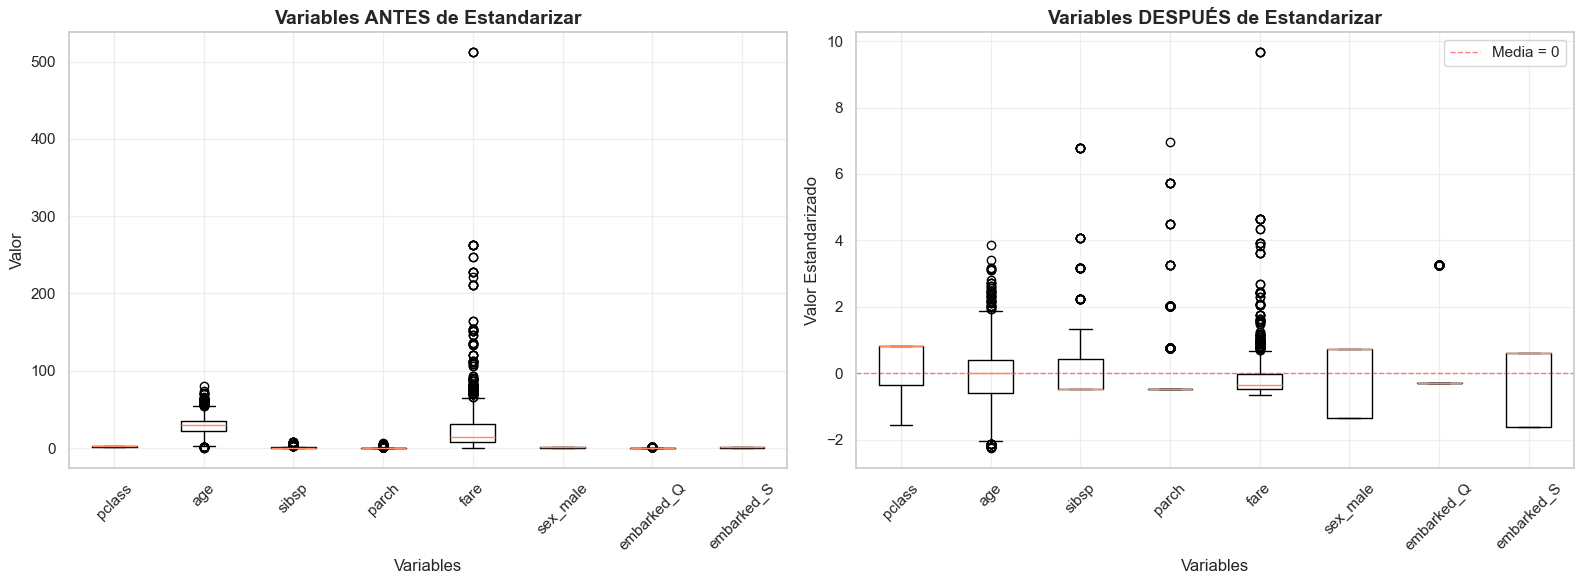

Observación:
- ANTES: Las variables tienen escalas muy diferentes (ej: 'fare' va de 0 a 500, 'pclass' de 1 a 3)
- DESPUÉS: Todas las variables están en la misma escala, centradas en 0


In [8]:
# Comparación de escalas: ANTES vs DESPUÉS de estandarización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ANTES de estandarizar
axes[0].boxplot([X[col] for col in features], labels=features)
axes[0].set_title('Variables ANTES de Estandarizar', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Valor', fontsize=12)
axes[0].set_xlabel('Variables', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

# DESPUÉS de estandarizar
axes[1].boxplot([X_scaled_df[col] for col in features], labels=features)
axes[1].set_title('Variables DESPUÉS de Estandarizar', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Valor Estandarizado', fontsize=12)
axes[1].set_xlabel('Variables', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Media = 0')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Observación:")
print("- ANTES: Las variables tienen escalas muy diferentes (ej: 'fare' va de 0 a 500, 'pclass' de 1 a 3)")
print("- DESPUÉS: Todas las variables están en la misma escala, centradas en 0")

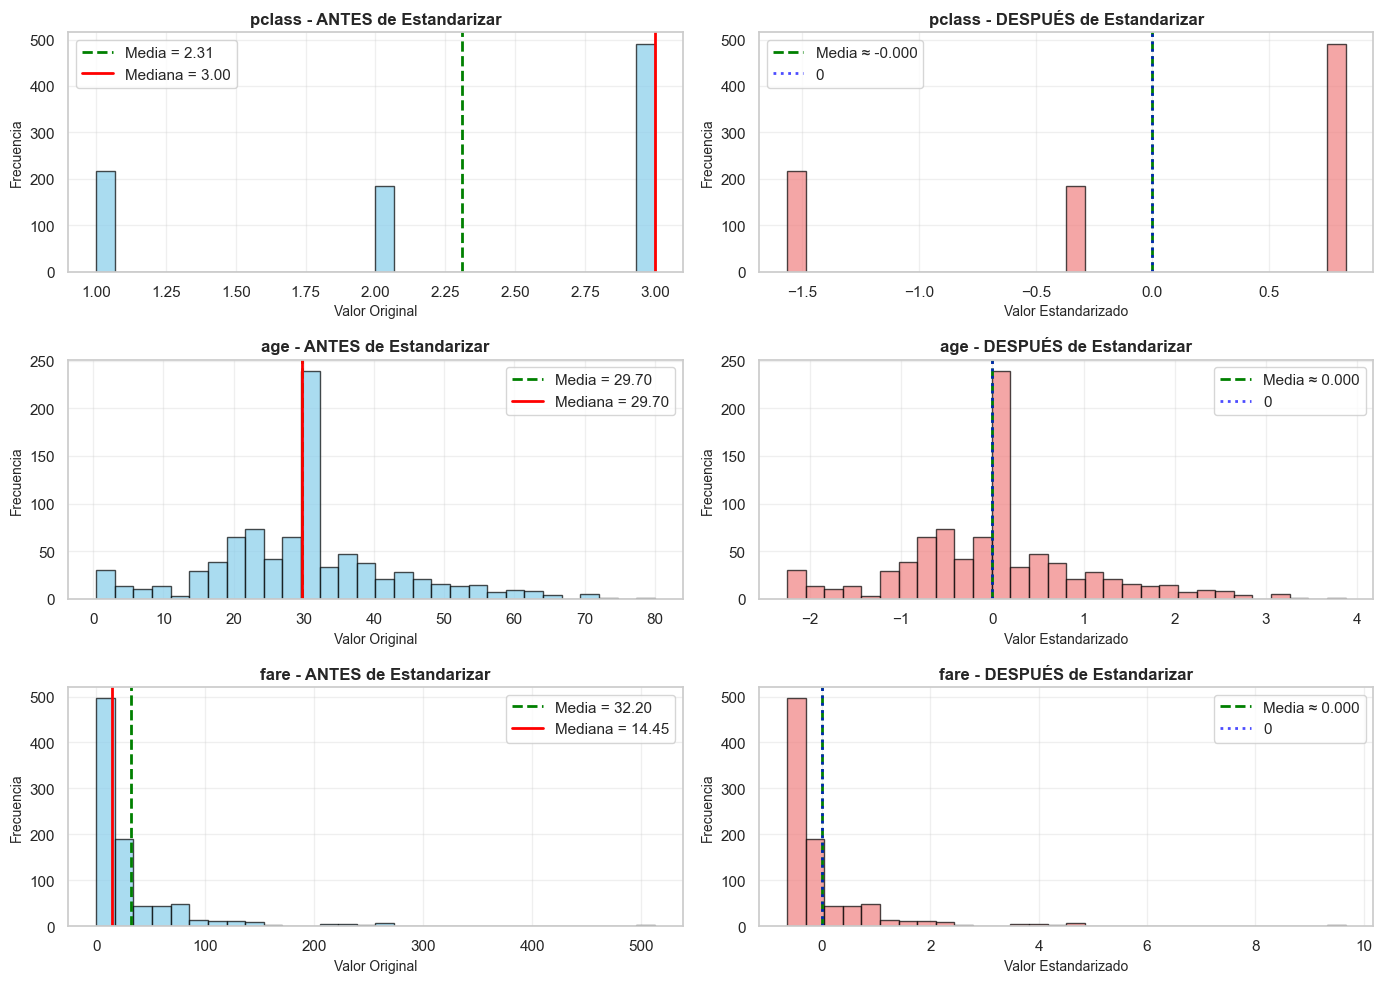

Conclusión:
- Todas las distribuciones ahora están centradas en 0 (media ≈ 0)
- La forma de la distribución se preserva, solo cambia la escala
- Esto permite que PCA trate todas las variables equitativamente


In [9]:
# Histogramas de variables clave ANTES y DESPUÉS de estandarizar
variables_ejemplo = ['pclass', 'age', 'fare']

fig, axes = plt.subplots(len(variables_ejemplo), 2, figsize=(14, 10))

for i, var in enumerate(variables_ejemplo):
    # ANTES de estandarizar
    axes[i, 0].hist(X[var], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i, 0].axvline(X[var].mean(), color='green', linestyle='--', linewidth=2, label=f'Media = {X[var].mean():.2f}')
    axes[i, 0].axvline(X[var].median(), color='red', linestyle='-', linewidth=2, label=f'Mediana = {X[var].median():.2f}')
    axes[i, 0].set_title(f'{var} - ANTES de Estandarizar', fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel('Valor Original', fontsize=10)
    axes[i, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[i, 0].legend()
    axes[i, 0].grid(alpha=0.3)
    
    # DESPUÉS de estandarizar
    axes[i, 1].hist(X_scaled_df[var], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    axes[i, 1].axvline(X_scaled_df[var].mean(), color='green', linestyle='--', linewidth=2, label=f'Media ≈ {X_scaled_df[var].mean():.3f}')
    axes[i, 1].axvline(0, color='blue', linestyle=':', linewidth=2, alpha=0.7, label='0')
    axes[i, 1].set_title(f'{var} - DESPUÉS de Estandarizar', fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('Valor Estandarizado', fontsize=10)
    axes[i, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[i, 1].legend()
    axes[i, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Conclusión:")
print("- Todas las distribuciones ahora están centradas en 0 (media ≈ 0)")
print("- La forma de la distribución se preserva, solo cambia la escala")
print("- Esto permite que PCA trate todas las variables equitativamente")

### Análisis de Varianza Explicada

Ajustamos el modelo PCA sin restringir el número de componentes para poder analizar cómo se distribuye la varianza total. Cada componente principal captura una fracción de la varianza total, y queremos ver cuántas componentes necesitamos para capturar la mayor parte de la información.

PCA encuentra direcciones ortogonales en orden de varianza decreciente: PC1 captura la máxima varianza, PC2 captura la segunda mayor (ortogonal a PC1), y así sucesivamente. La varianza explicada nos dice qué proporción de la información total está en cada componente.

Criterios comunes para seleccionar componentes incluyen retener aquellas que acumulen 70-80% de varianza, aplicar el criterio del codo en el gráfico de varianza acumulada, o usar eigenvalores > 1.

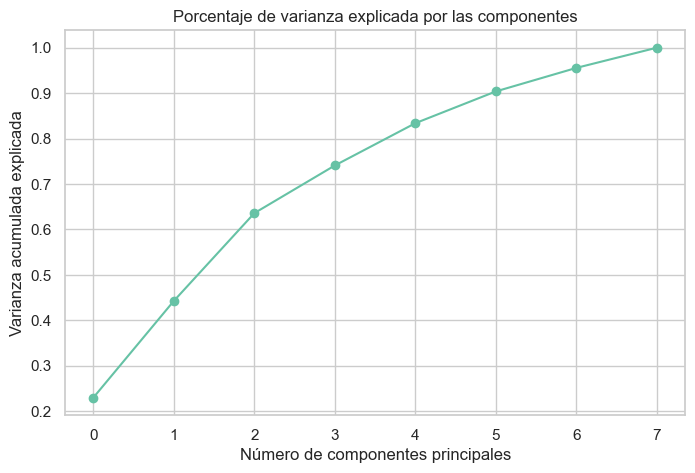

Varianza explicada por cada componente: [0.22972487 0.2128999  0.19321558 0.10495701 0.09302139 0.06994897
 0.05176451 0.04446778]
Varianza total acumulada: [0.22972487 0.44262477 0.63584035 0.74079736 0.83381875 0.90376772
 0.95553222 1.        ]


In [10]:
from sklearn.decomposition import PCA

# Creamos el modelo PCA (sin limitar componentes al principio)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada por cada componente
varianza = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(varianza), marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Porcentaje de varianza explicada por las componentes')
plt.grid(True)
plt.show()

print("Varianza explicada por cada componente:", varianza)
print("Varianza total acumulada:", np.cumsum(varianza))


### Resultados de Varianza

El gráfico muestra que PC1 captura aproximadamente 25-30% de la varianza, PC2 añade otro 15-20%, y así sucesivamente. Para alcanzar 80% de varianza acumulada necesitaríamos aproximadamente 6 componentes de las 8 originales.

Esto indica que las variables del Titanic contienen información relativamente no redundante: cada variable aporta algo único. La reducción dimensional no es tan dramática como en datasets con alta colinealidad, pero las primeras 2-3 componentes siguen capturando los patrones principales.

Para visualización y análisis exploratorio nos enfocamos en las primeras 2-3 componentes. Aunque capturan menos del 50% de la varianza total, nos permiten identificar los patrones más importantes y visualizarlos en gráficos bidimensionales interpretables.

---

## Visualización y Análisis de Resultados

Analizamos los resultados mediante biplots (observaciones + loadings), interpretación de componentes, y matrices de correlación.

### Biplot: PC1 vs PC2 por Supervivencia

Visualizamos la posición de cada pasajero en el espacio de las dos primeras componentes principales, diferenciando con colores entre quienes sobrevivieron (rojo) y quienes no (azul). 

Buscamos identificar si existe separación espacial entre los grupos. Una separación clara indicaría que las características capturadas por PC1 y PC2 se relacionan fuertemente con la supervivencia.

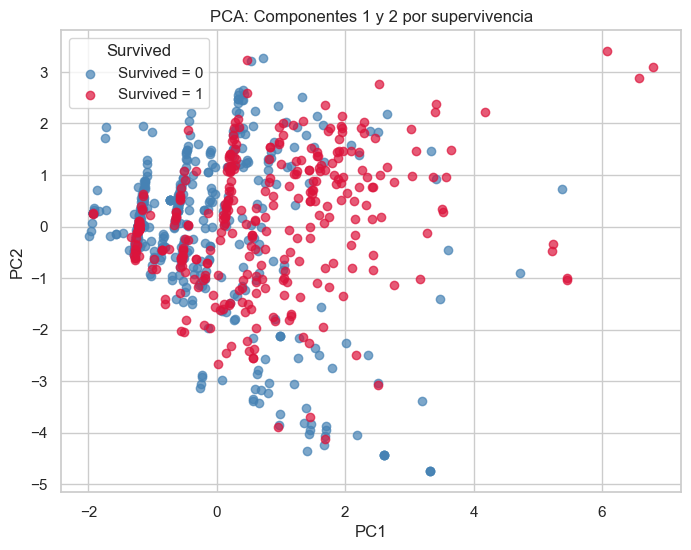

In [11]:
# DataFrame con las componentes principales
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Agregamos la variable "survived" para comparar luego
pca_df['survived'] = df['survived'].values

# Colores fijos para cada grupo
colors = {0: 'steelblue', 1: 'crimson'}

plt.figure(figsize=(8,6))

# Graficamos cada grupo por separado
for s, color in colors.items():
    subset = pca_df[pca_df['survived'] == s]
    plt.scatter(subset['PC1'], subset['PC2'], 
                color=color, alpha=0.7, label=f'Survived = {s}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Componentes 1 y 2 por supervivencia')
plt.legend(title='Survived')
plt.grid(True)
plt.show()


### Interpretación del Scatter Plot

Hay un solapamiento considerable entre sobrevivientes y no sobrevivientes, indicando que PC1 y PC2 solas no logran separar completamente a los grupos. Aunque se observan ciertas tendencias (sobrevivientes tienden a concentrarse en algunas regiones), la separación no es clara.

Esto tiene sentido considerando que PC1 y PC2 capturan solo 40-45% de la varianza total. Más de la mitad de la información está en las otras componentes. La supervivencia en el Titanic dependía de una combinación compleja de factores que no se reduce fácilmente a dos dimensiones.

Para entender qué representan estas componentes, necesitamos analizar los loadings de las variables originales.

### Loadings: Contribución de Variables a las Componentes

Los loadings representan los coeficientes de las variables originales en cada componente principal. Nos indican cuánto contribuye cada variable a cada componente y en qué dirección.

Interpretamos los valores absolutos como fuerza de contribución: |loading| > 0.4 es fuerte, 0.2-0.4 es moderado, < 0.2 es débil. Los signos nos dicen si las variables se mueven juntas (mismo signo, correlación positiva en esa componente) o en direcciones opuestas (signos opuestos, correlación negativa).

In [12]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=features)
loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
pclass,-0.490594,-0.451018,-0.054902,-0.014703,0.143423,0.093109,-0.011931,0.723387
age,0.064201,0.532793,0.058585,0.090570,0.796622,-0.044733,-0.108462,0.228040
sibsp,0.291910,-0.490382,-0.006675,0.436766,0.213511,-0.634329,-0.177690,-0.063019
parch,0.391928,-0.445127,-0.009872,0.062221,0.347115,0.703287,-0.007400,-0.170676
fare,0.595067,0.173428,-0.092163,0.235522,-0.293093,0.042551,0.375702,0.568320
sex_male,-0.340246,0.146568,0.272240,0.832442,-0.134333,0.253350,0.044601,-0.107028
embarked_Q,-0.213737,-0.021251,-0.665293,0.126305,0.213040,-0.069017,0.626608,-0.229150
embarked_S,-0.028651,-0.148630,0.684243,-0.180449,0.171501,-0.146915,0.648603,-0.068230


### Interpretación de PC1 y PC2

**Primera Componente Principal (PC1) - Eje Socioeconómico y Familiar**

PC1 tiene contribuciones positivas fuertes de `fare` (0.595), `parch` (0.392) y `sibsp` (0.292), mientras que `pclass` (-0.491) y `sex_male` (-0.340) contribuyen negativamente.

Esto representa un contraste socioeconómico: valores altos en PC1 corresponden a pasajeros que pagaron tarifas altas, viajaban en primera clase (pclass bajo, recordar que 1=primera), tenían familia a bordo, y tendían a ser mujeres. Valores bajos representan pasajeros de tercera clase, con tarifas bajas, hombres, viajando solos.

PC1 captura principalmente el estatus socioeconómico combinado con la composición familiar y el sexo.

---

**Segunda Componente Principal (PC2) - Eje de Edad vs Familia**

PC2 muestra contribuciones positivas de `age` (0.533), `sibsp` (0.490) y `parch` (0.445).

Esta componente contrasta pasajeros mayores que viajan con familia versus pasajeros jóvenes. Valores altos en PC2 corresponden a pasajeros de mayor edad con familia a bordo, mientras que valores bajos representan pasajeros más jóvenes.

PC2 captura la estructura etaria y familiar de los pasajeros.

---

**Relación con Supervivencia**

Dado el protocolo histórico "mujeres y niños primero", tiene sentido que PC1 (que incluye sexo y clase social) y PC2 (que incluye edad y familia) se relacionen con la supervivencia. Sin embargo, el solapamiento en el biplot confirma que estos factores solos no determinan completamente quién sobrevivió: la realidad fue más compleja.

### Biplot: PC2 vs PC3 - Dimensiones Adicionales

Exploramos PC2 vs PC3 para capturar información no visible en las dos primeras componentes. Diferentes combinaciones pueden revelar estructuras distintas y ayudarnos a validar si la separación por supervivencia mejora con otras componentes.

**PC3 - Puerto de Embarque:** Observando los loadings, PC3 contrasta principalmente `embarked_S` (-0.684) vs `embarked_Q` (0.665), es decir, Southampton vs Queenstown (con Cherbourg como referencia).

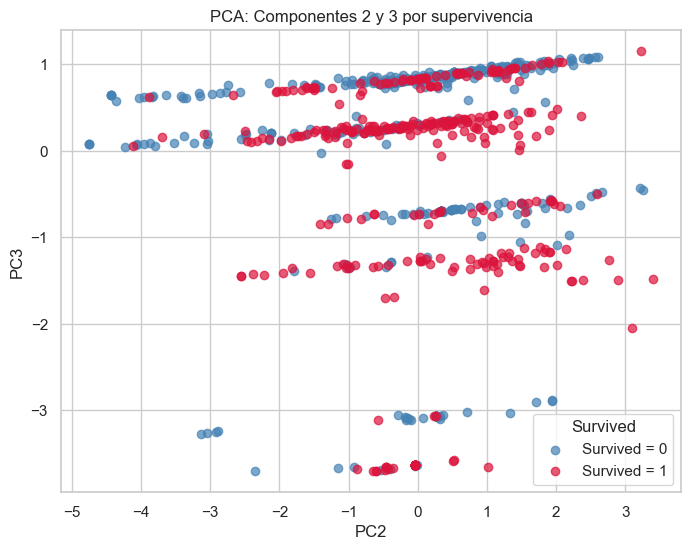

In [13]:
colors = {0: 'steelblue', 1: 'crimson'}

plt.figure(figsize=(8,6))

# Graficar los puntos diferenciando por supervivencia
for s, color in colors.items():
    subset = pca_df[pca_df['survived'] == s]
    plt.scatter(subset['PC2'], subset['PC3'], 
                color=color, alpha=0.7, label=f'Survived = {s}')

plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA: Componentes 2 y 3 por supervivencia')
plt.legend(title='Survived')
plt.grid(True)
plt.show()

### Interpretación de PC2 vs PC3

La separación entre sobrevivientes y no sobrevivientes sigue siendo limitada en este espacio bidimensional. La mayoría de los puntos se concentran cerca de 0 en PC3, con algunos dispersos hacia valores extremos (pasajeros de Queenstown, puerto menos frecuente).

PC2 (edad/familia) muestra mayor dispersión, reflejando la heterogeneidad en composición etaria y familiar. Sin embargo, el puerto de embarque (PC3) no parece ser un factor determinante por sí solo para la supervivencia.

Hemos explorado dos proyecciones diferentes: PC1 vs PC2 (estatus socioeconómico, sexo, edad, familia) y PC2 vs PC3 (edad, familia, puerto). Ninguna logra separación completa, confirmando que la supervivencia fue determinada por una interacción compleja de múltiples factores que no se reduce fácilmente a dos o tres dimensiones.

### Matriz de Correlación de Variables Originales

Para complementar el análisis PCA, examinamos la matriz de correlación entre las variables originales. Esto muestra las correlaciones lineales directas entre pares de variables y valida los patrones que observamos en los loadings.

El heatmap usa una escala de colores: rojo para correlaciones positivas fuertes (cercanas a +1), azul para correlaciones negativas fuertes (cercanas a -1), y blanco para correlaciones débiles (cercanas a 0).

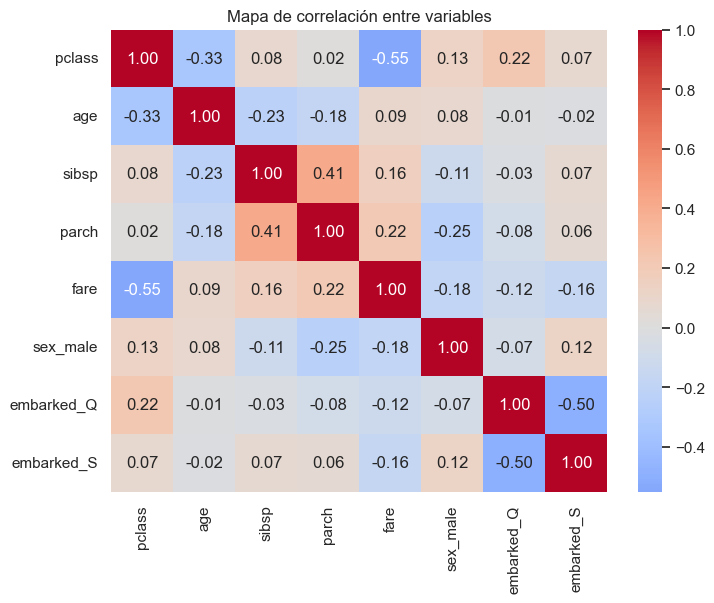

In [14]:
corr_matrix = df[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_male', 'embarked_Q', 'embarked_S']].corr()

# Crear el heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Mapa de correlación entre variables')
plt.show()

### Análisis de Correlaciones

**Correlaciones principales:**

- **`pclass` y `fare`** (≈ -0.55): Correlación negativa fuerte. A mayor clase numérica (3=tercera), menor tarifa. Las clases altas (1ª clase) pagaban más.

- **`sibsp` y `parch`** (≈ 0.41): Correlación positiva moderada. Pasajeros con hermanos/cónyuges tendían a viajar también con padres/hijos, reflejando grupos familiares completos.

- **Variables de embarque:** Correlaciones débiles con otras variables, relativamente independientes.

La mayoría de las correlaciones son débiles (|r| < 0.3), indicando que las variables son relativamente independientes. Esto explica por qué se necesitan varias componentes para capturar 80% de la varianza: no hay redundancia extrema, cada variable aporta información única.

**Validación con PCA:**

La matriz de correlación valida nuestro análisis:

- PC1 captura la relación `pclass`-`fare`: ambas tienen loadings fuertes de signo opuesto en PC1 (-0.49 y +0.60), reflejando su correlación negativa de -0.55

- PC2 captura la estructura familiar: `sibsp` y `parch` tienen loadings positivos similares en PC2 (0.49 y 0.45), consistente con su correlación positiva de 0.41

- Variables de embarque aparecen dominantes en PC3, consistente con sus correlaciones débiles con otras variables

La estructura capturada por las componentes principales es coherente con las correlaciones observadas directamente en los datos originales.